## Location Analysis and Post-Hoc Attention Maps
#### First part deals with the total correct/incorrect predictions for flare class within central locations and limb regions. 
#### Second Part is about generating post hoc attention maps using three of the following methods:
##### 1. Guided GradCam
##### 2. Integrated Gradients
##### 3. DEEPSHAP 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn.functional as F

from torchvision import models

from captum.attr import IntegratedGradients, DeepLiftShap, GuidedGradCam

from captum.attr import visualization as viz

from torch.utils.data import Dataset, DataLoader
import warnings
warnings.simplefilter("ignore", Warning)
import torch.nn as nn 
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 5000)
plt.rcParams['figure.dpi'] = 1000

In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 2, dropout: float = 0.5) -> None:
        super().__init__()
        
        self.first_conv_layer = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True),
            nn.ReLU()
            )

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.first_conv_layer(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



In [3]:
class MyJP2Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)

        if self.transform:
            image = self.transform(hmi)
            
        y_prob = round(float((self.annotations.iloc[index, 1])), 2)
        y_label = str(self.annotations.iloc[index, 2])
        
        return (image, y_prob, y_label)

    def __len__(self):
        return len(self.annotations)

In [4]:
#Loading Model on CPU
device = torch.device('cpu')
model_PATH1 = 'trained_models/new-fold1.pth'
weights1 = torch.load(model_PATH1, map_location=torch.device("cpu"))
test_model = AlexNet().to(device)
test_model.load_state_dict(weights1['model_state_dict'])
test_model.eval()

AlexNet(
  (first_conv_layer): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False

In [5]:
#Gathering all Validation Predictions
fold1_val = pd.read_csv('fold1_res.csv')
fold2_val = pd.read_csv('fold2_res.csv')
fold3_val = pd.read_csv('fold3_res.csv')
fold4_val = pd.read_csv('fold4_res.csv')
total = pd.concat([fold1_val, fold2_val, fold3_val, fold4_val])
total['timestamp'] = pd.to_datetime(total['timestamp'])
total.reset_index(inplace=True)

#Merging the predictions with flare locations data
details = pd.read_csv('M_full_dataset_cleaned_1_hours_with_loc_and_time_new.csv')
details['timestamp'] = details['label'].apply(lambda row: row[16:-4])
details['timestamp'] = pd.to_datetime(details['timestamp'], format='%Y.%m.%d_%H.%M.%S')
details.drop(columns=['label'], inplace=True)
df = total.merge(details, how='left', on='timestamp')


### PART ONE: LOCATION ANALYSIS

In [6]:
def location_analysis(df, flareclass):
    X = df.loc[(df.goes_class.str.startswith(flareclass))].copy()
    X[["x", "y"]] = X["fl_location"].str.strip(r"[()]").str.split(",", expand=True).astype(str)
    X['x'] = pd.to_numeric(X['x']).round(decimals=2).astype(str).replace(r'\.0$', '', regex=True)
    X[["x", "y"]] = X[['x', 'y']].astype(float)
    pos = X[(X.flare_prob>=0.5)]
    neg = X[(X.flare_prob<0.5)]
    pos_limb = len(pos.loc[(pos.x<-70) | (pos.x>70)])+len(pos.loc[(pos.y<-70) | (pos.y>70)])
    neg_limb = len(neg.loc[(neg.x<-70) | (neg.x>70)])+ len(neg.loc[(neg.y<-70) | (neg.y>70)])
    pos_center = len(pos.loc[(pos.y>=-70) & (pos.y<=70) & (pos.x>=-70) & (pos.x<=70)])
    neg_center = len(neg.loc[(neg.y>=-70) & (neg.y<=70) & (neg.x>=-70) & (neg.x<=70)])
    print(f'*************{flareclass} Class flares locations***************')
    print("Total Instances: ", len(X))
    print('With in Central Locations')
    print('TP: ', pos_center, 'FN: ', neg_center)
    print('Beyond Central Locations (Limb Locations)')
    print('TP: ', pos_limb, 'FN: ', neg_limb, '\n')
    
location_analysis(df.copy(), 'X')
location_analysis(df.copy(), 'M')

*************X Class flares locations***************
Total Instances:  880
With in Central Locations
TP:  637 FN:  31
Beyond Central Locations (Limb Locations)
TP:  157 FN:  55 

*************M Class flares locations***************
Total Instances:  8120
With in Central Locations
TP:  4229 FN:  1601
Beyond Central Locations (Limb Locations)
TP:  1143 FN:  1147 



### PART TWO: POST HOC ATTENTION MAPS EXAMPLES

In [7]:
#Preparing Data
def date_to_filename(df):
    cols=['timestamp']
    for items in cols:

        df[items] = pd.to_datetime(df[items], format='%Y-%m-%d %H:%M:%S')

        #Renaming label(Date) to this format of file HMI.m2010.05.21_12.00.00 
        df[items] = df[items].dt.year.astype(str) + '/' \
            + df[items].dt.month.map("{:02}".format).astype(str) + '/'\
            + df[items].dt.day.map("{:02}".format).astype(str) + '/'+ 'HMI.m'+ df[items].dt.year.astype(str) + '.' \
            + df[items].dt.month.map("{:02}".format).astype(str) + '.'\
            + df[items].dt.day.map("{:02}".format).astype(str) + '_' \
            + df[items].dt.hour.map("{:02}".format).astype(str) + '.'\
            + df[items].dt.minute.map("{:02}".format).astype(str) + '.'\
            + df[items].dt.second.map("{:02}".format).astype(str) + '.jpg'
    
    return df
df = date_to_filename(df)

df_c = df.loc[(df.goes_class.str.startswith('C')) & (df.flare_prob>=0.9)]
df_x = df.loc[(df.goes_class.str.startswith('X'))]
cols = ['timestamp', 'flare_prob', 'goes_class', 'fl_location', 'flare_start']
df_c.to_csv(r'c_class.csv', index=False, header=True, columns=cols)
df_x.to_csv(r'x_class.csv', index=False, header=True, columns=cols)

In [8]:
c_csv_file = 'c_class.csv'
x_csv_file =  'x_class.csv'
data_path = '/data/hmi_jpgs_512/'
data_transforms = Compose([ToTensor()])
dataset_c = MyJP2Dataset(csv_file = c_csv_file , 
                             root_dir = data_path,
                             transform = data_transforms)
dataset_x = MyJP2Dataset(csv_file = x_csv_file , 
                             root_dir = data_path,
                             transform = data_transforms)
batch_size = 880
c_loader = DataLoader(dataset=dataset_c, batch_size=batch_size, shuffle = False)
x_loader = DataLoader(dataset=dataset_x, batch_size=batch_size, shuffle = False)

In [9]:
dataiter_c = iter(c_loader)
images_c, _, labels_c = dataiter_c.next()
dataiter_x = iter(x_loader)
images_x, _, labels_x = dataiter_x.next()

#### Manually Choosing One example each for True Positive and False Positive

In [10]:


ind_TP = 359
ind_FP = 69

input_c = images_c[ind_FP].unsqueeze(0)
input_c.requires_grad = True
input_x = images_x[ind_TP].unsqueeze(0)
input_x.requires_grad = True

### Post Hoc Attention Methods

In [11]:
def attribute_image_features(algorithm, input, **kwargs):
    test_model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=1,
                                              **kwargs
                               )
    return tensor_attributions

def guidedgradcam(inpt, images, indx, target,flag):
    plt.rcParams['figure.dpi'] = 300
    guided_gc = GuidedGradCam(test_model, test_model.features[10])
    grads = guided_gc.attribute(inpt, target=target)
    grads = np.transpose(grads.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((images[indx].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    fig, ax = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",alpha_overlay=0.6,
                              show_colorbar=True)
    fig.savefig(f'{flag}_gradcam.pdf')
    
def deepshap(inpt, images, indx, target,flag):
    saliency = DeepLiftShap(test_model)
    grads = saliency.attribute(inpt, baselines= images[347:364], target=1)
    grads = np.transpose(grads.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((images[indx].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    fig, ax = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",alpha_overlay=0.6,
                              show_colorbar=True)
    fig.savefig(f'{flag}_deeplift.pdf')
    

def intgrad(inpt, images, indx, target,flag):
    ig = IntegratedGradients(test_model)
    attr_ig, delta = attribute_image_features(ig, inpt, baselines=inpt * 0, return_convergence_delta=True)
    attr_ig = np.transpose(attr_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((images[indx].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
#     print('Approximation delta: ', abs(delta))
    fig, ax = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="absolute_value",alpha_overlay=0.6,
                              show_colorbar=True)
    fig.savefig(f'{flag}_intgrad.pdf')

### TRUE POSITVE CASE with all THREE Methods

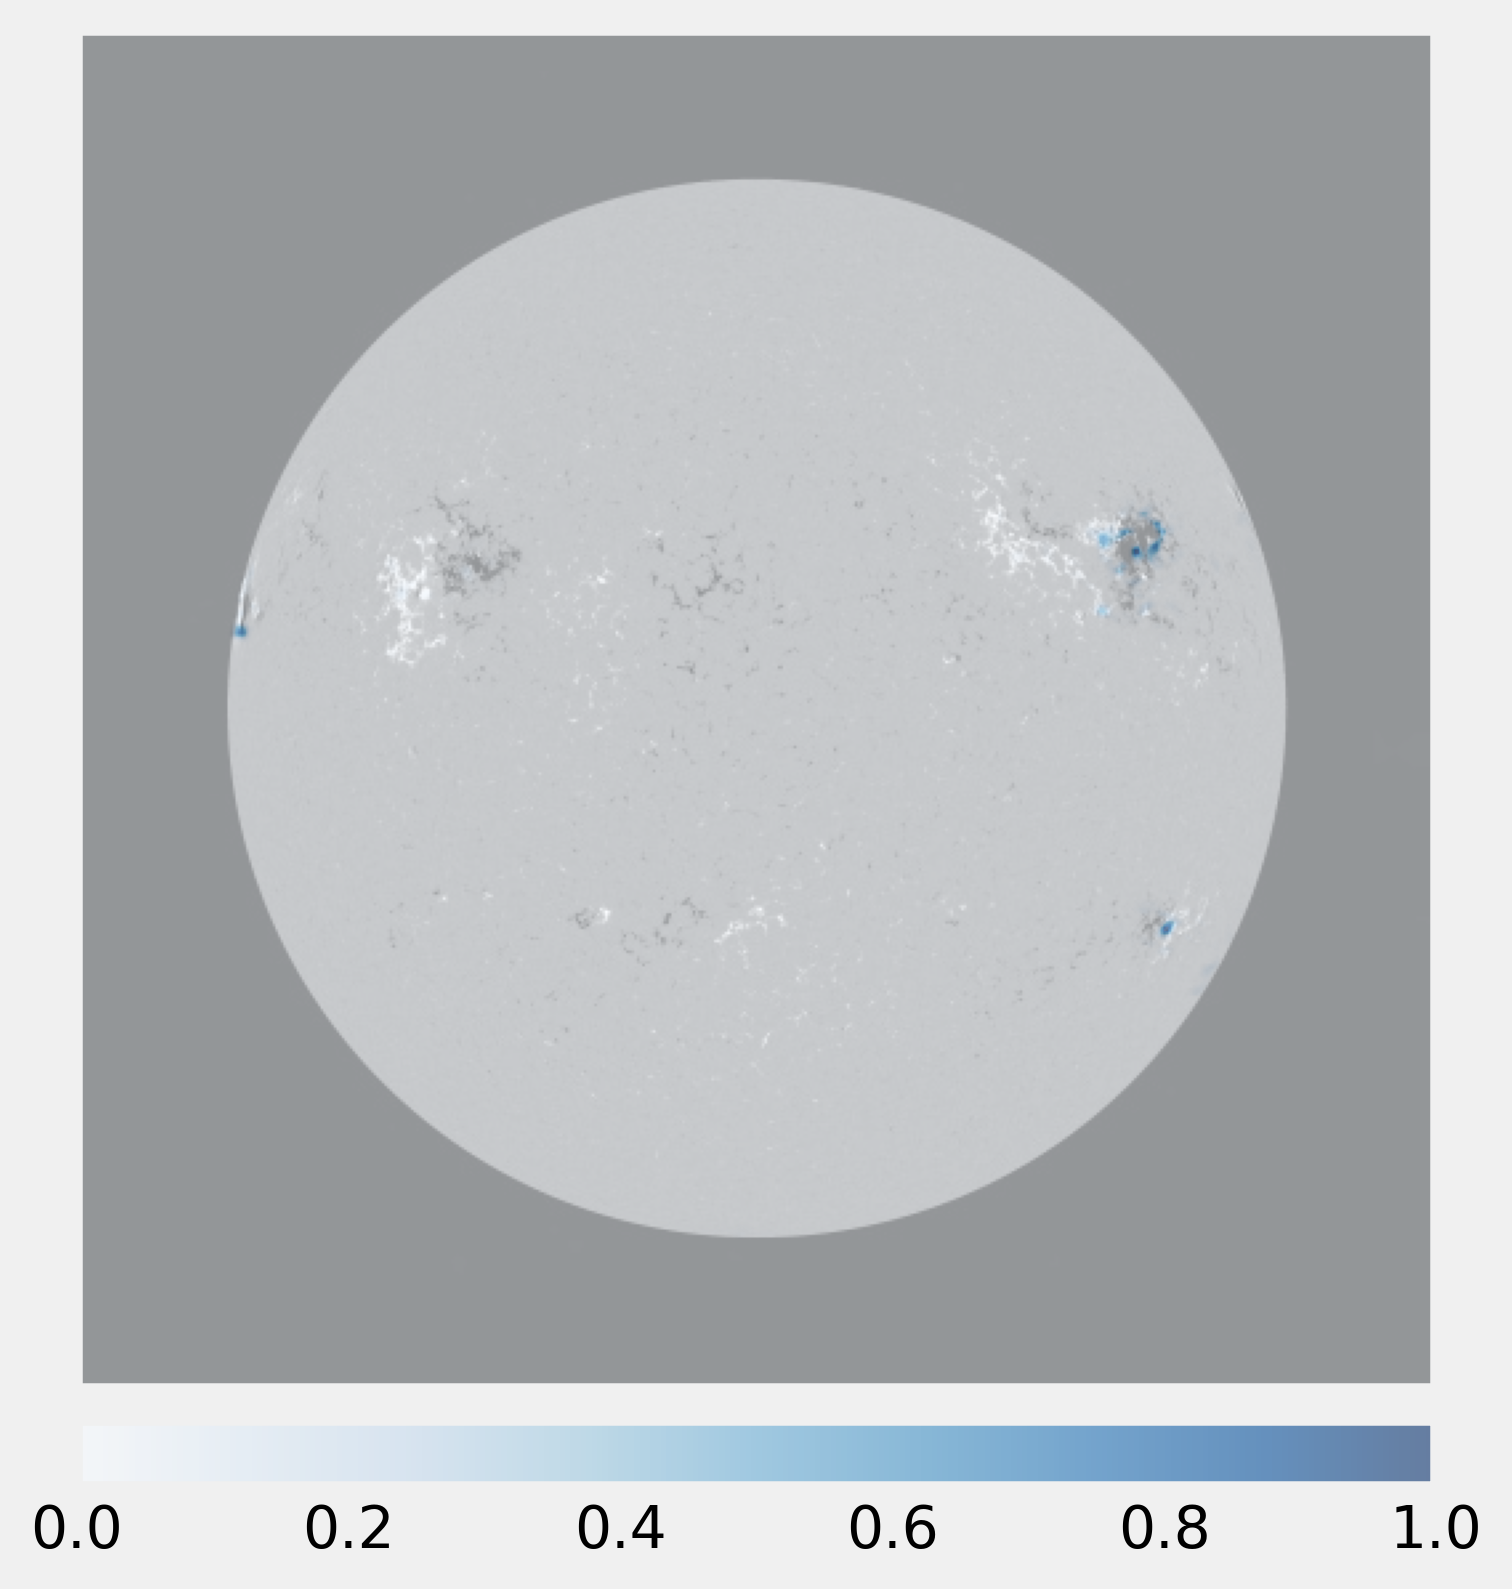

In [12]:
guidedgradcam(input_x, images_x, ind_TP, 1,'TP')

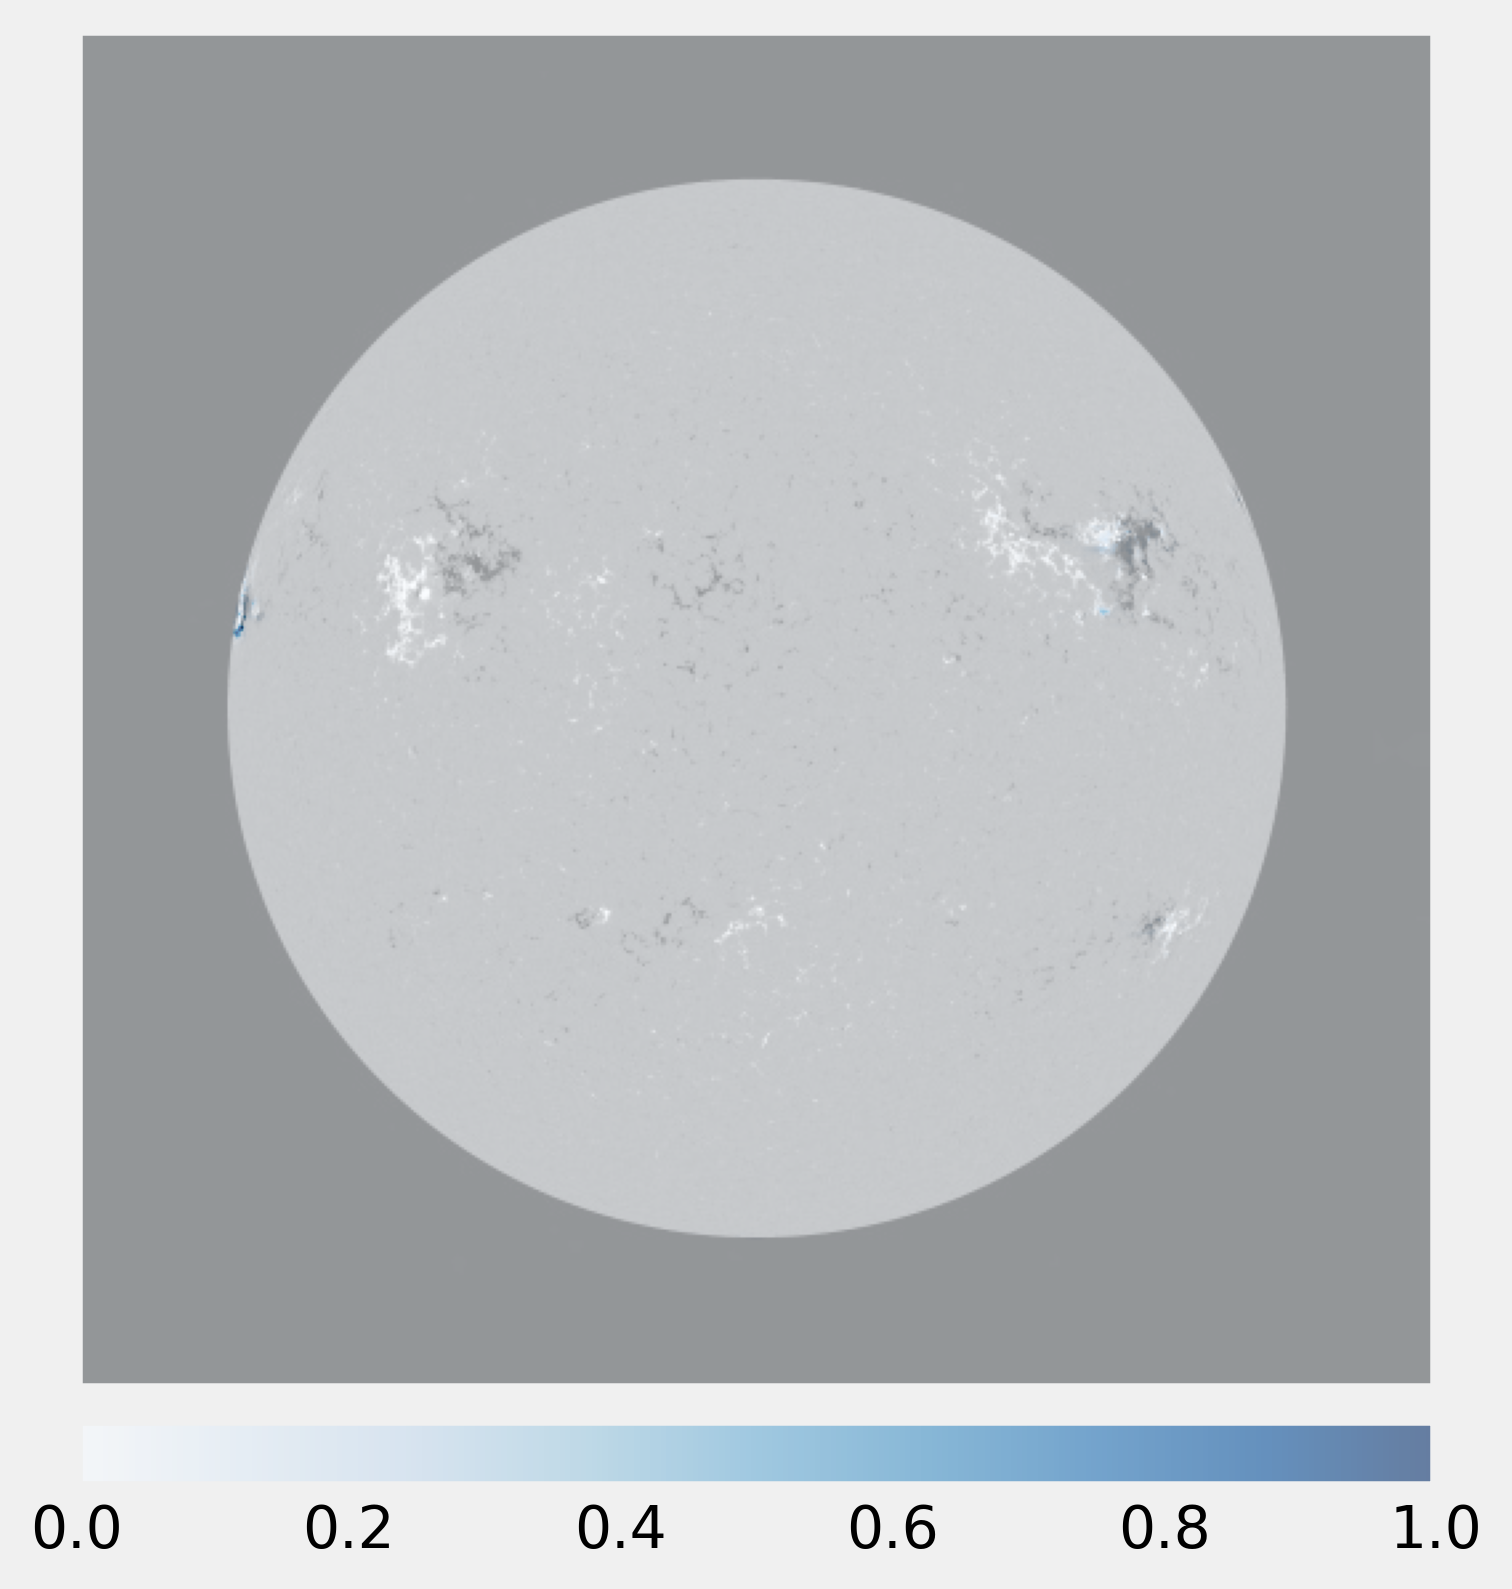

In [13]:
deepshap(input_x, images_x, ind_TP, 1,'TP')

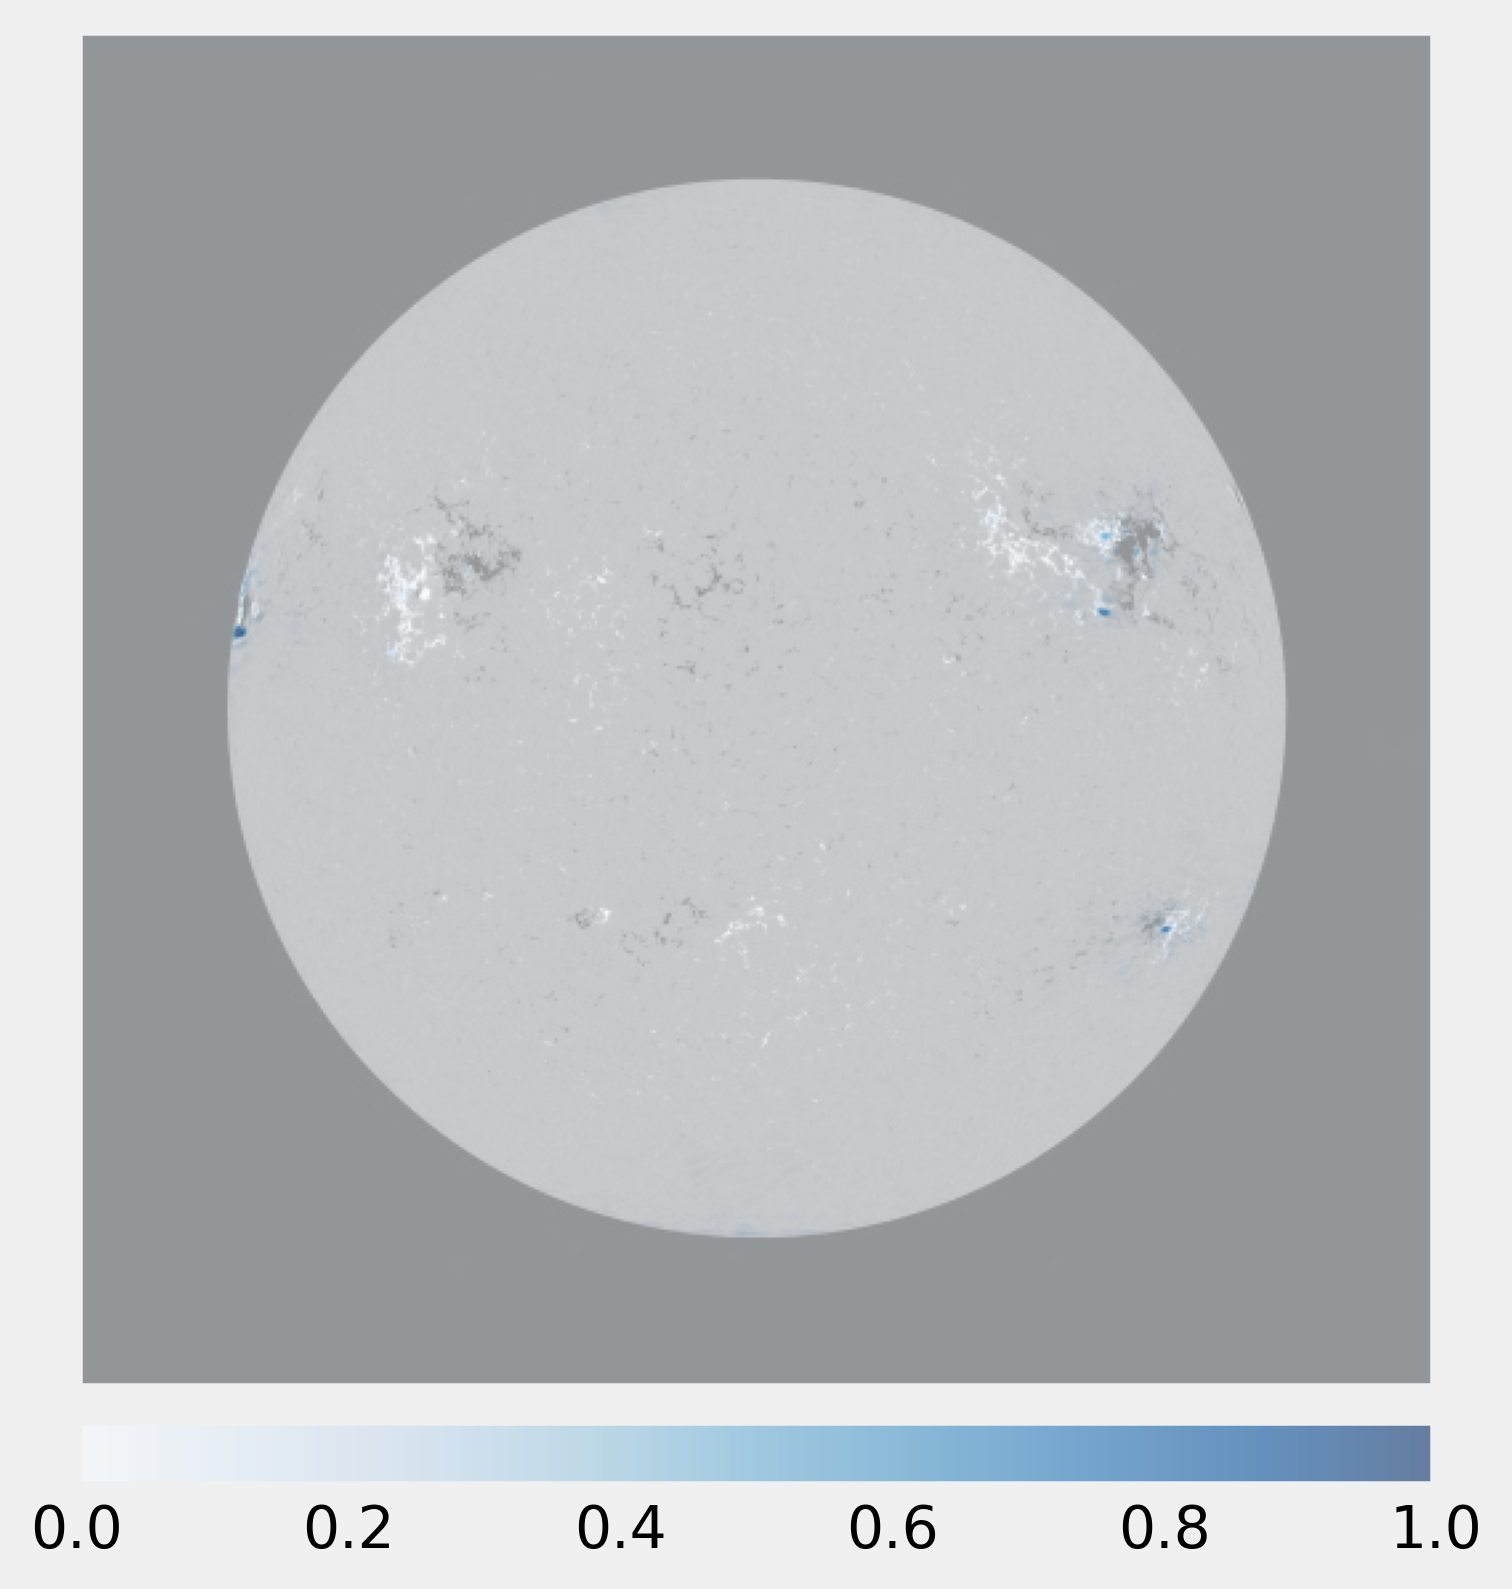

In [14]:
intgrad(input_x, images_x, ind_TP, 1,'TP')

### FALSE POSITIVE CASE with all THREE Methods

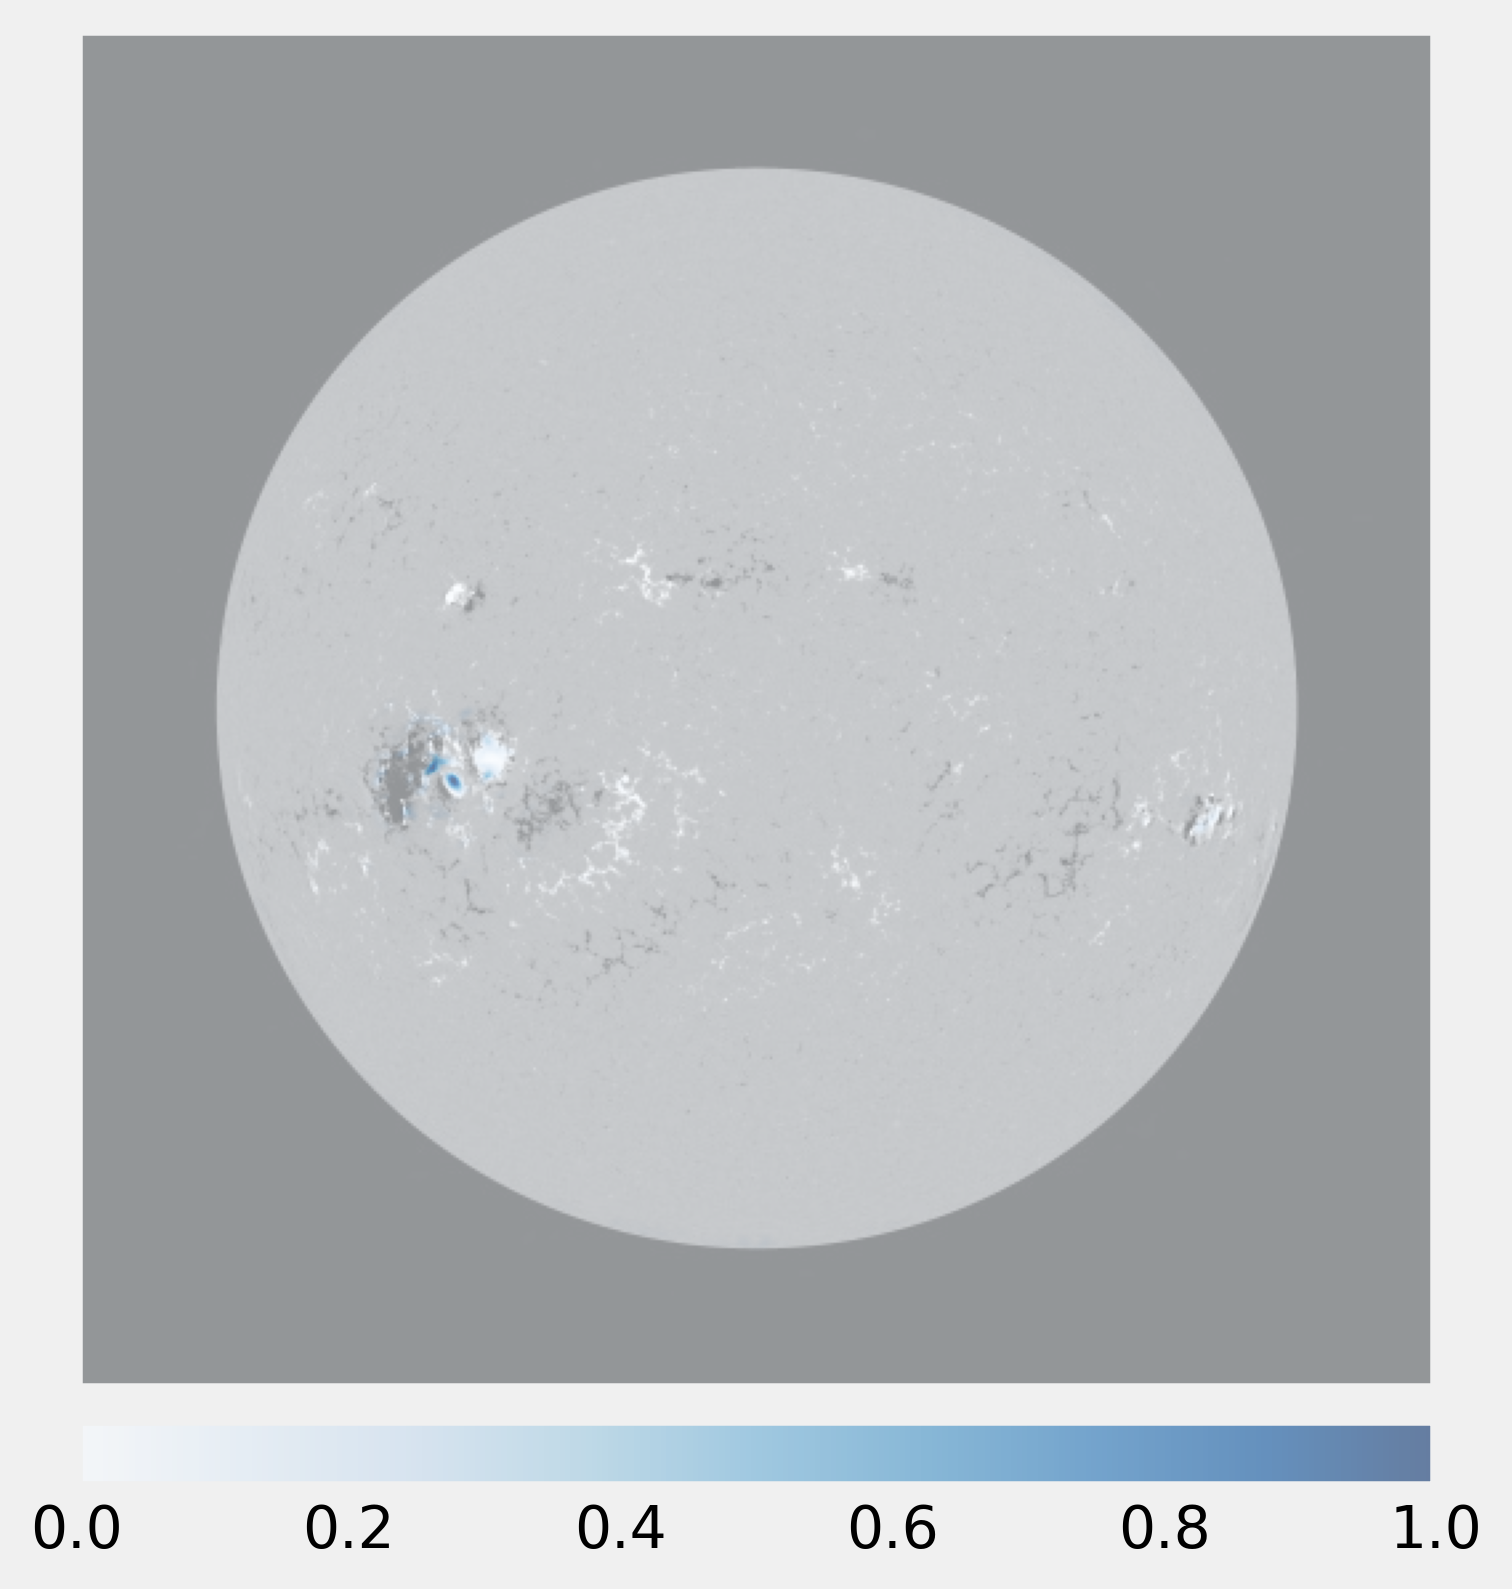

In [15]:
guidedgradcam(input_c, images_c, ind_FP, 0,'FP')

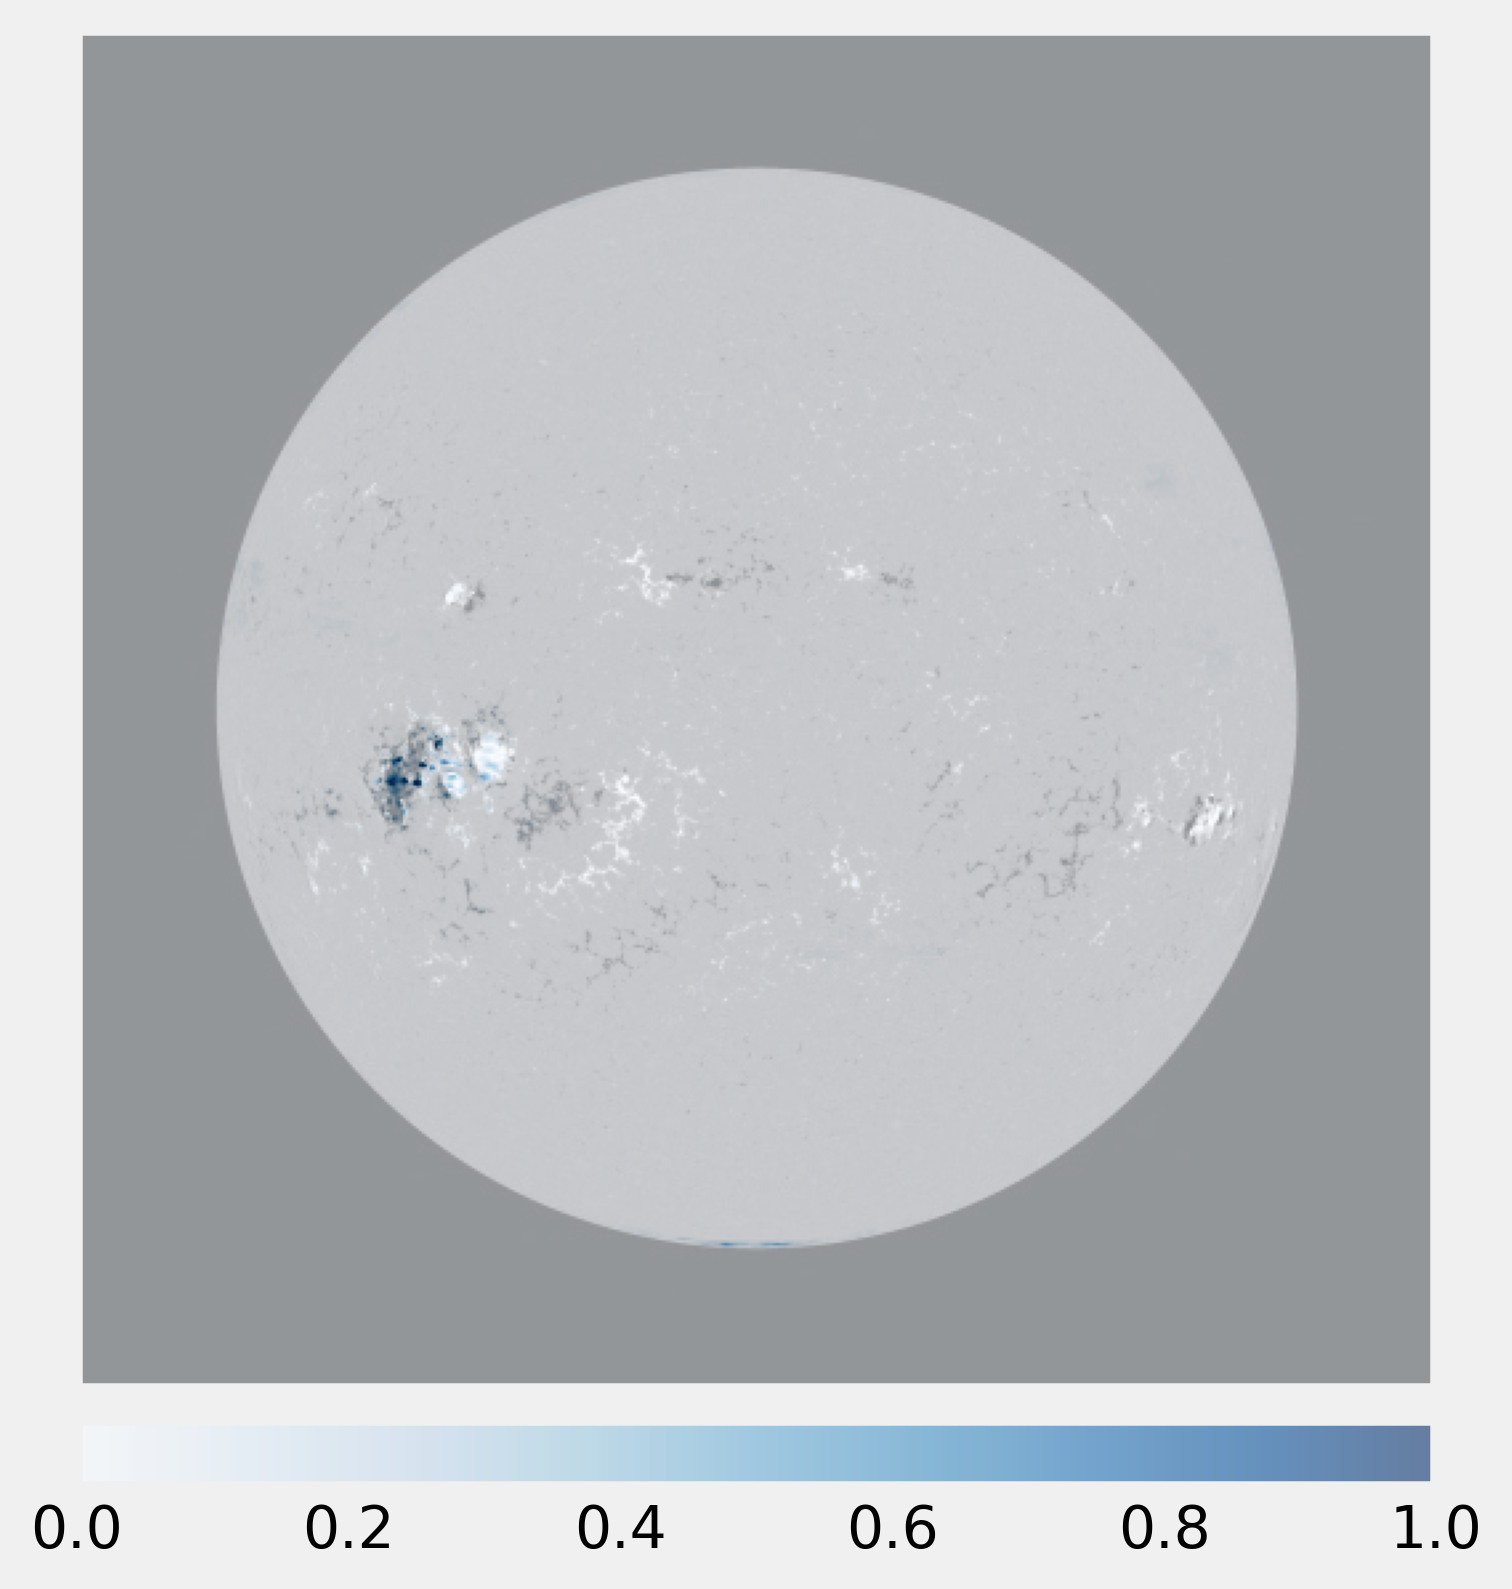

In [16]:
deepshap(input_c, images_c, ind_FP, 0,'FP')

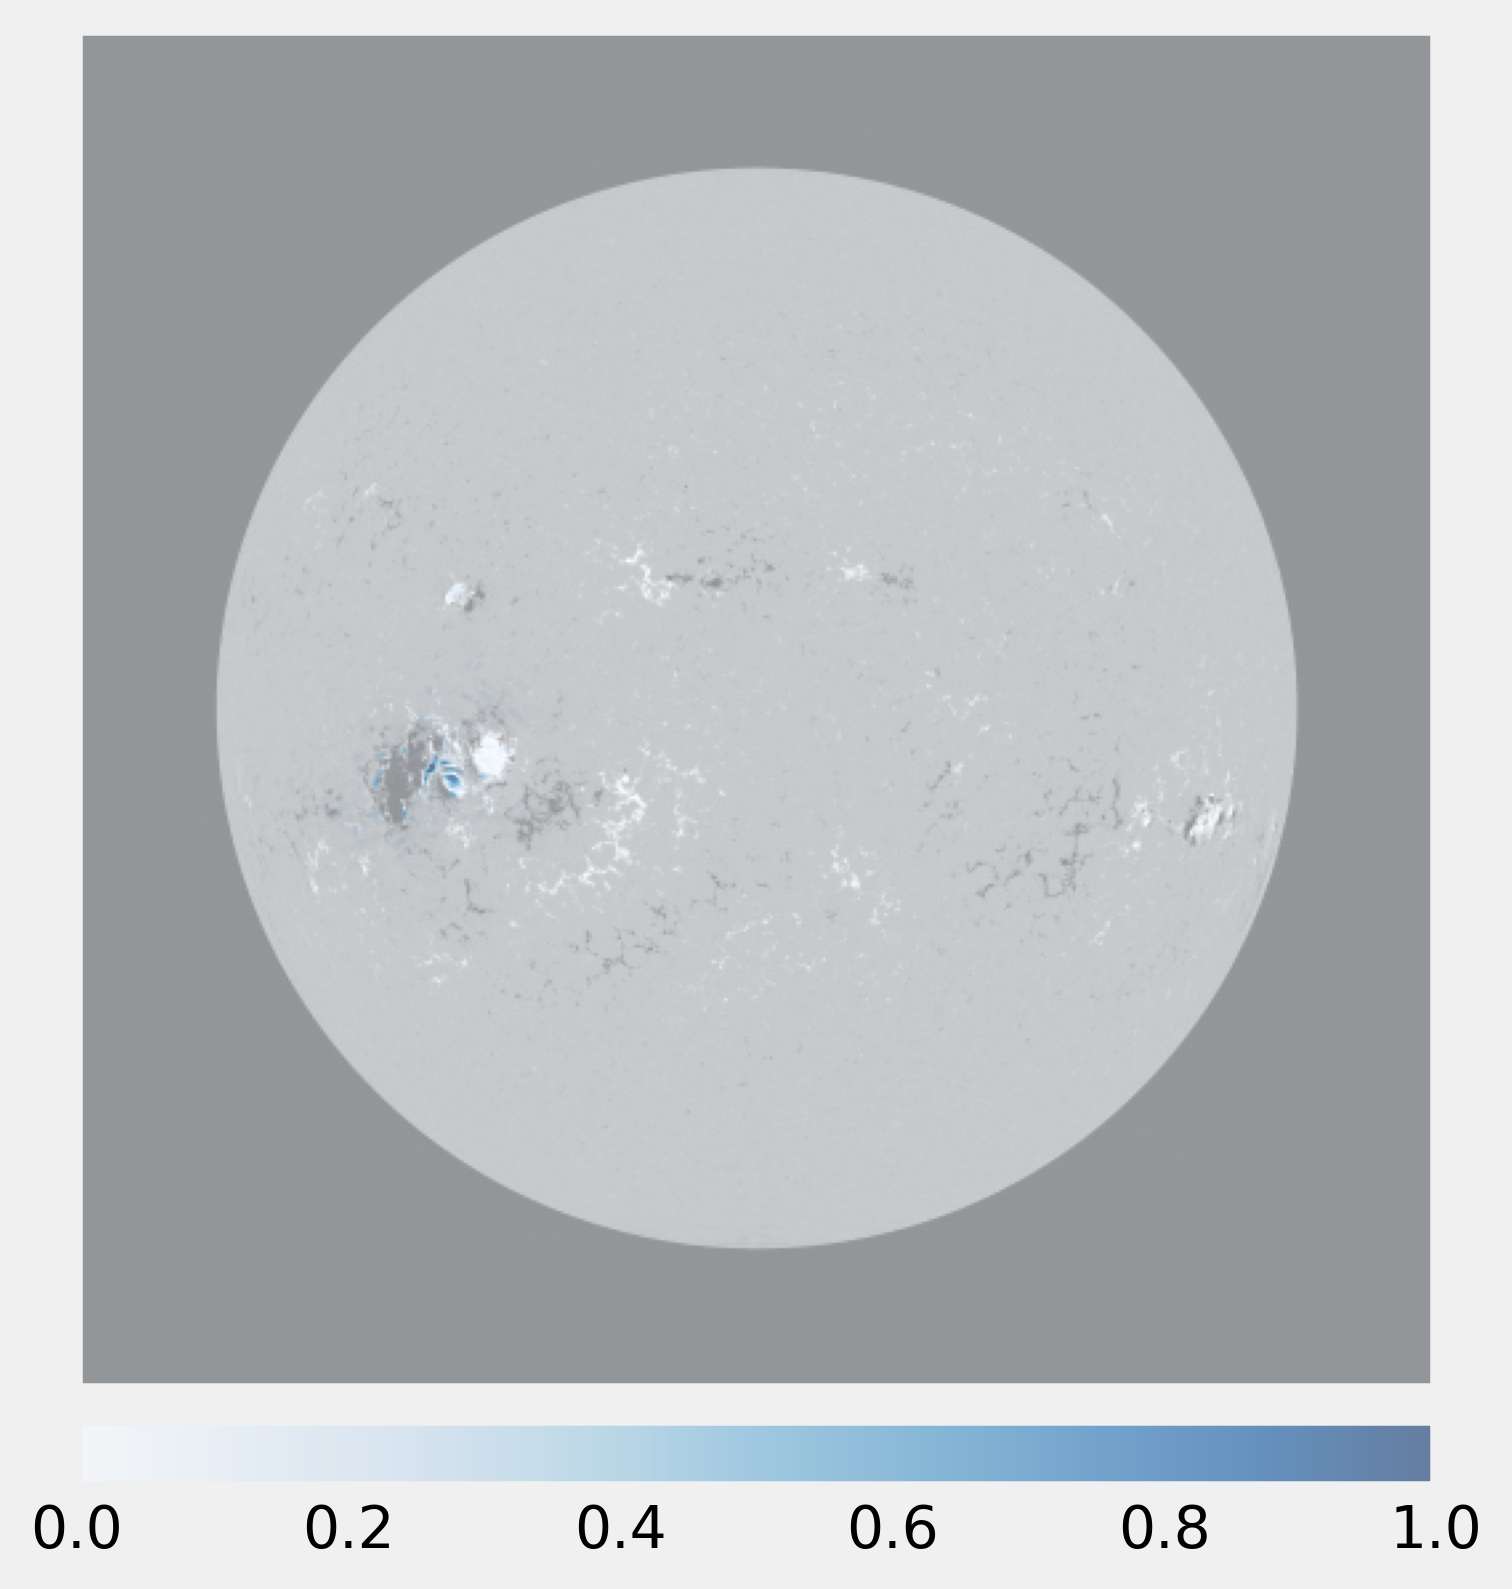

In [17]:
intgrad(input_c, images_c, ind_FP, 0,'FP')